<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
     <td align="left"; style="background-color:transparent; width: 33%;"><a href="http://www.math-evry.cnrs.fr/departement/doku.php?id=formation:master:m2ds"><img src="https://github.com/ramp-kits/scMARK_classification/raw/main/evry_logo.png" width="65%"></a></td>
    <td align="center"; style="background-color:transparent; width: 33%;"><a href = "https://dataia.eu/"><img src="https://github.com/ramp-kits/bovine_embryo_survival_prediction/raw/main/DATAIA-h.png" width="80%"></a></td>
    <td align="right"; style="background-color:transparent; width: 33%;"><a href="https://www.inrae.fr"><img src="https://www.inrae.fr/themes/custom/inrae_socle/logo.svg" width="40%"></a></td>
  </tr>
</table> 
</div>


<center><h1>Single-cell RNA-seq classification</h1></center>

<center><h3>A RAMP data-challenge on the prediction of cellular types based on genes expression level </h3></center>
<br/>


<center><i>Nicolas Jouvin (MIA Paris-Saclay, Associate Professor @ Univ. Paris-Saclay), François Caud (DATAIA, Univ. Paris-Saclay) </i></center>

<center><h4> This data-challenge was created for the data-camp course of the Master 2 Data-Science of Université Évry (Paris-Saclay) </h4></center>

# Introduction 

Biologically, [it is known that](https://www.ncbi.nlm.nih.gov/books/NBK26885/), while cells carry (almost) the same genomic information, they tend to *express* only a fraction of their genes leading to specialization into specific *types* with different biological functions. Thus, cell-types study and classification is of primary interest for many biological and medical applications. In the past decade, measuring genes expression level at the scale of a unique cell has become possible with the rise of high-throughput technologies named single-cell RNA-seq (scRNA-seq).

The goal of this data challenge is the **supervised** classification of cell-types thanks to the **scMARK** benchmark dataset from [Mendonca et. al](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1). The authors compiled 100, 000 cells expression from 10 different studies to serve as a comparison for different machine learning approaches, in an analogy with the MNIST benchmark dataset for computer vision. 

This data-challenge uses a small extraction with only 4 cell-types (the labels to predict) from **scMARK**:

    1. Cancer_cells
    2. NK_cells
    3. T_cells_CD4+
    4. T_cells_CD8+
    
The public dataset contains 1500 points splitted in 1000 training points and 500 test points. It will serve as your local benchmark for developing your submissions. On the server side, your submission will use the whole 1500 public points as the training set, and another **private and unavailable test** dataset, containing 1500 supplementary test points, will be used for the ranking of participants. The labels' distribution in the public (resp. private) training and testing datasets are the same.

# Setup 

If marked as `code`, the two following cells will 

* install the required package dependencies
* download the public data on OSF

They are disabled by default since you only have to call these command once (in your dedicated Python env). You can examine the file, `requirements.txt`, included in the repo to view the list of dependencies.

<div class="alert alert-block alert-info">
<b>Info:</b> Due to the structure of the challenge, libraries not included in `requirements.txt` will need to be added via a pull request to the <a href=https://github.com/ramp-kits/scMARK_classification> GitHub repo </a>.
</div> 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# The data 

### Loading data 
Raw data are stored in h5ad format which can be read via the `scanpy.read_h5ad` function which returns an [AnnData](https://anndata.readthedocs.io/) object.

The `problem.py` file contains the definition of the data-challenge according to the RAMP framework. In addition, it contains an helper functions to import data. 

In [2]:
from problem import get_train_data, get_test_data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

#### Labels proportions
A first inspection of the labels indicates that the classes are imbalanced. 
> Note: the same analysis may be conducted for y_test.

In [3]:
lab_df = pd.DataFrame({'label': y_train})
lab_df.value_counts(normalize=True)

label       
T_cells_CD8+    0.342
T_cells_CD4+    0.336
Cancer_cells    0.237
NK_cells        0.085
Name: proportion, dtype: float64

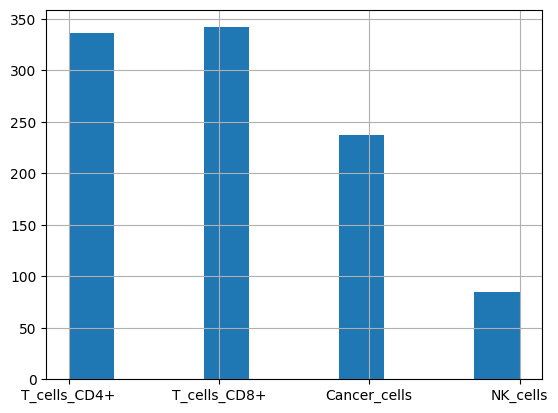

In [4]:
lab_df.label.hist();

#### Sparse matrix and NumPy arrays

Secondly, looking at the features

In [5]:
print(X_train.shape)
print(type(X_train))

(1000, 13551)
<class 'scipy.sparse._csr.csr_matrix'>


We see that we have a fairly high dimensional problem with 1000 data points (unique cells) described by 14059 variables (genes). Since we measure expression level, the data is quite sparse, with many unexpressed genes for each cell. Thus, `get_*_data()` functions returns $X$ as a `scipy` [sparse matrix stored in row format](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). This is useful 

    1. To save memory space
    2. Some algorithm may work with scipy's sparse CSR matrices.

Of course many existing algorithm, *e.g.* in scikit-learn, may throw error when given such an object, requiring a `np.array` type. Thankfully the `.toarray()` method straightforwadly converts to NumPy.

In [6]:
X_train.toarray()

array([[1., 0., 0., ..., 3., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1000, 13551), dtype=float32)

### A first look at the data

<div class="alert alert-block alert-warning">
<b>Warning:</b> This section purposedly presents a naive example of data manipulation. It is expected of you to dive deeper into the data analysis and do proper pre-processing. 

</div> 


A particularity of RNA-seq data is that total counts may vary widely between cells and/or genes.


In [7]:
total_genes_counts = X_train.toarray().sum(axis=0)
total_cell_counts = X_train.toarray().sum(axis=1)

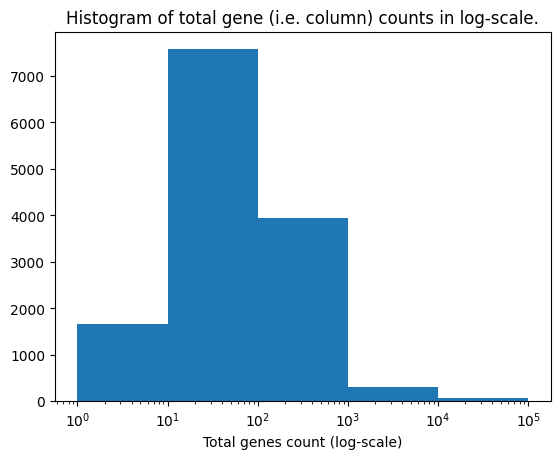

In [8]:
# plt.hist(np.log10(total_genes_counts), bins = np.arange(6))
plt.hist(total_genes_counts, bins = 10**np.arange(6))
plt.xscale("log")
plt.title("Histogram of total gene (i.e. column) counts in log-scale.")
plt.xlabel('Total genes count (log-scale)')
plt.show()

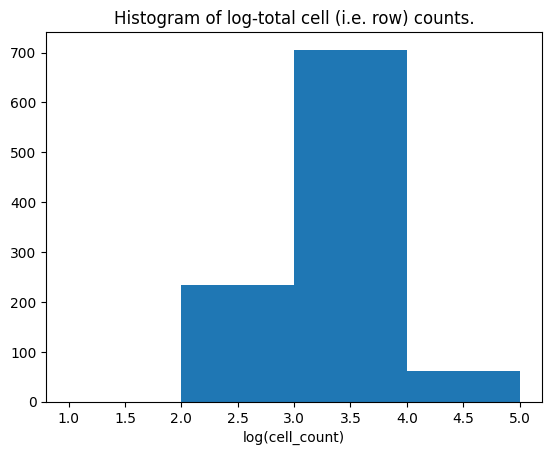

In [9]:
plt.hist(np.log10(total_cell_counts), bins = np.arange(1,6))
plt.title("Histogram of log-total cell (i.e. row) counts.")
plt.xlabel('log(cell_count)')
plt.show()

This suggests for some normalization of the counts. There are many normalization possible for RNA-seq data, and one of the goal of this challenge is to test for different pre-processing. For simplicity, here we choose to normalize each row (cell) by its total count.

In [10]:
def preprocess_X(X):
    X = X.toarray()
    return X / X.sum(axis=1)[:, np.newaxis]

X_train_norm = preprocess_X(X_train)
# sanity check
np.allclose(X_train_norm.sum(axis=1), np.ones(X_train_norm.shape[0]))

True

# The score function

This challenge scores your submissions and ranks participants with a balanced accuracy score, computed via the (unadjusted) sklearn's `balanced_accuracy_score` function.

Balanced accuracy is computed as the average of Recall scores for each class [see implementation for more details](https://github.com/scikit-learn/scikit-learn/blob/8c9c1f27b/sklearn/metrics/_classification.py#L2180). It is between 0 and 1, the higher, the better.

In [11]:
from sklearn.metrics import balanced_accuracy_score

In [12]:
# this custom class is used by the challenge and calls 
# balanced_accuracy_score(y_true, y_pred, adjusted=False)
# under the hood
from problem import BalancedAccuracy

# A first (naive) try at the challenge
We now show a first naive attempt at the challenge, and will proceed in two steps :

    1. First, we will construct a classifier step-by-step. 
    2. Then, we will show how to implement this classifier as a proper RAMP submision.
## Step-by-step construction of a classifier

Given the high-dimensional nature of the problem we will construct a classifier: standardize data, do a PCA retaining only the 50 first components, and finally fit a random forest classifier on the 50 first components.

This can be easily implemented as a scikit-learn `Pipeline`.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


pipe = Pipeline(
    [
        ("Scaler", StandardScaler(with_mean=True, with_std=True)),
        ("PCA with 50 components", PCA(n_components=50)),
        (
            "Random Forest Classifier",
            RandomForestClassifier(
                max_depth=5, n_estimators=100, max_features=3
            ),
        ),
    ]
)

pipe

,steps,"[('Scaler', ...), ('PCA with 50 components', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,50
,copy,True
,whiten,False
,svd_solver,'auto'


In [14]:
# fit on train
pipe.fit(X_train_norm, y_train)
y_tr_pred = pipe.predict(X_train_norm)

# predict on test
X_test_norm = preprocess_X(X_test)
y_te_pred = pipe.predict(X_test_norm)


Train balanced accuracy : 0.698
Test balanced accuracy : 0.583


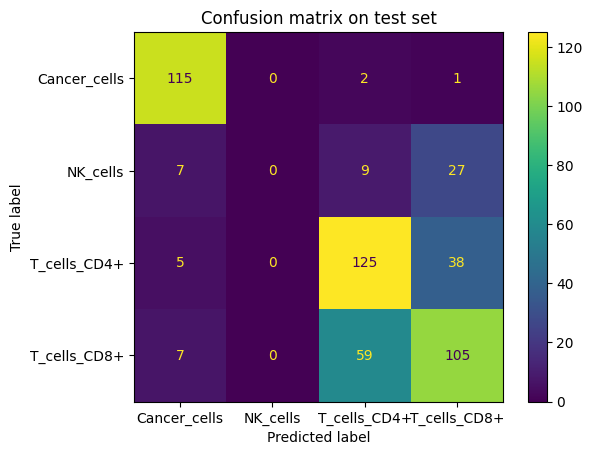

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set");

This naive classifier does a better job than a dummy random classifier which would yield an average balanced accuracy of 1/4. 
However, it never predicts the "NK_cell" type and seems to confuse between the two different "T-cell" types. There seems to be room for improvement. Good news, it is your job ! :)

Next, let's see how to implement this exact same classifier as a receivable RAMP submission

## Designing the RAMP submission
The RAMP challenge is automatized and a submission requires a specific structure described below.


### Mandatory structure of a submission


A submission is stored in `./submissions/<submission_foldername>/` and must contain a Python file named `classifier.py`.

This python script must itself implement (at least) a custom `Classifier` class with
 * A `fit(X, y)` method.
 * A `predict_proba(X)` method.
 
**Warning**: the `X` argument must be understood as the sparse CSR count data matrix obtained by `get_train_data()`. Thus any pre-processing of the count matrix must be done inside the methods.

We illustrate this below with the naive classifier already implemented.

### Illustration with the naive classifier

> Note: The following class is also implemented in `./submissions/starting_kit/classifier.py`.

In [16]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


def _preprocess_X(X_sparse):
    # cast a dense array
    X = X_sparse.toarray()

    # normalize each row
    return X / X.sum(axis=1)[:, np.newaxis]


class Classifier(object):
    def __init__(self):
        # Use scikit-learn's pipeline
        self.pipe = make_pipeline(
            StandardScaler(with_mean=True, with_std=True),
            PCA(n_components=50),
            RandomForestClassifier(
                max_depth=5, n_estimators=100, 
                max_features=3
            ),
        )

    def fit(self, X_sparse, y):
        X = _preprocess_X(X_sparse)
        self.pipe.fit(X, y)
        self.classes_ = self.pipe.classes_
        pass

    def predict_proba(self, X_sparse):
        X = _preprocess_X(X_sparse)
        # here we use RandomForest.predict_proba()
        return self.pipe.predict_proba(X)


Below is a simplified version of what RAMP does with your submission.

In [17]:
clf = Classifier()
clf.fit(X_train, y_train)
# predict_proba 
y_tr_pred_proba = clf.predict_proba(X_train)
y_te_pred_proba = clf.predict_proba(X_test)

# convert to hard classification with argmax
y_tr_pred = clf.classes_[np.argmax(y_tr_pred_proba, axis=1)]
y_te_pred = clf.classes_[np.argmax(y_te_pred_proba, axis=1)]

In [18]:
print('Train balanced accuracy:', balanced_accuracy_score(y_train, y_tr_pred))
print('Test balanced accuracy:', balanced_accuracy_score(y_test, y_te_pred))

Train balanced accuracy: 0.6872574018503693
Test balanced accuracy: 0.5689143409370885


In reality things are a bit more sophisticated. **Locally**, the RAMP platform averages your classifier preformance over a 5-fold cross-validation scheme implemented for you in the `get_cv` method. The good news is, RAMP automatize everything for you thanks to `ramp-test`. The public train, validation and test performance are shown to you for information. 


<div class="alert alert-block alert-info">
<b>A note on hyper-parameter search</b> RAMP does not perform hyper-parameter tuning, nor grid-search for you. You need to implement this locally, on your own machine, and fix the hyper-parameters by hand in your Classifier class when sending your submission. Another option is to use K-fold cross-validation in the `fit()` method of your classifier, but it could lead to heavy computation times that would delay your research. </a>.
</div> 



### Submitting to RAMP

Before submitting to RAMP, you can test your solution locally to ensure that trivial errors (e.g. typos, path issues, etc.) are resolved. We can test a given submission using the `ramp-test` command that was installed in the virtual environment.  

We'll use the following command:  

`!ramp-test --submission <subm_folder> --quick-test` 

The `!` signals that the command should be run on the command line instead of this notebook.  
`ramp-test` is the command to be executed. It signals ramp to perform a local test. 

`--submission <subm_folder>` specifies which submission to run. You can have multiple potential submissions in the `submissions/` directory; this prevents `ramp` from running all of them (and by default it runs starting_kit).  

In [19]:
!ramp-test --submission random_classifier

Testing Single-cell RNA-seq cell types classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions\random_classifier ...
CV fold 0
	score  bal_acc  time
	train     0.25   0.0
	valid     0.24   0.0
	test      0.24   0.0
CV fold 1
	score  bal_acc  time
	train     0.25   0.0
	valid     0.24   0.0
	test      0.23   0.0
CV fold 2
	score  bal_acc      time
	train     0.26  0.015483
	valid     0.21  0.000000
	test      0.26  0.000000
CV fold 3
	score  bal_acc      time
	train     0.27  0.003416
	valid     0.29  0.000000
	test      0.23  0.000000
CV fold 4
	score  bal_acc      time
	train     0.26  0.003825
	valid     0.24  0.000000
	test      0.25  0.000000
----------------------------
Mean CV scores
----------------------------
	score       bal_acc        time
	train  0.26 ± 0.006  0.0 ± 0.01
	valid  0.24 ± 0.026   0.0 ± 0.0
	test   0.24 ± 0.011   0.0 ± 0.0
----------------------------
Bagged scores
----------------------------
	score  bal_acc
	valid     

We see that the mean CV scores are consistent with the previous result we had. If you use a classifier with more variance, you would see more variation accross CV-folds. 

<div class="alert alert-info"> 
    
<b>Note on style complicance</b> Every `submissions/*.py` files will be checked for style compliance before running on RAMP server. It is done thanks to the [flake8](https://flake8.pycqa.org/en/latest/) package. Before submitting, you need to fix any error raised by the following terminal command
    
`$flake8 submissions/`
<br/>

The **black** auto-formatting tool works very well to automatically format your code accoring to flake8 standard when saving your files in VScode or PyCharm IDEs. 

You might want to check [this page](https://flake8.pycqa.org/en/3.1.1/user/ignoring-errors.html) for ignoring specific errors in some corner-cases. 

</div>

## Ranking & Leaderboard

**On the server**, the participants are ranked according to the balanced accuracy score on the private test data set. However, only the ranking will be available, and not the score in itself in order to avoid overfitting of this private test set. The score on public test will be available as a proxy but your submission could very well have a better ranking on private with a worst balanced accuracy on public. 

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

# Now it's your turn

---

# scMARK Analysis: EDA & Preprocessing Strategy

**Objective**
Build a robust supervised classifier to predict 4 cell types (Cancer, NK, CD4+ T, CD8+ T) from raw single-cell RNA-seq count data.

**The Nature of scRNA-seq Data**
Before modeling, we analyze the fundamental properties of the data to justify our preprocessing choices:
1.  **Overdispersion:** We verify if the data follows a Poisson distribution (Mean = Variance) or a Negative Binomial distribution (Variance > Mean).
2.  **Sparsity:** We analyze the relationship between mean gene expression and "dropout" rate (percentage of zeros).

**Preprocessing Pipeline**
Based on these properties, we will apply a standard bioinformatics pipeline:
* **Library Size Normalization:** Corrects for technical differences in sequencing depth (total reads per cell).
* **Log1p Transformation:** Stabilizes the variance of the data (correcting overdispersion).
* **Feature Selection:** Filters out uninformative genes (low variance/noise) to reduce dimensionality.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import umap

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.svm import SVC
from sklearn.model_selection import (GridSearchCV, cross_val_predict, cross_val_score, StratifiedKFold)
from sklearn.metrics import (classification_report, balanced_accuracy_score, ConfusionMatrixDisplay)

sns.set_theme(style="whitegrid")

warnings.filterwarnings("ignore", message="Features .* are constant")
warnings.filterwarnings("ignore", category=UserWarning)

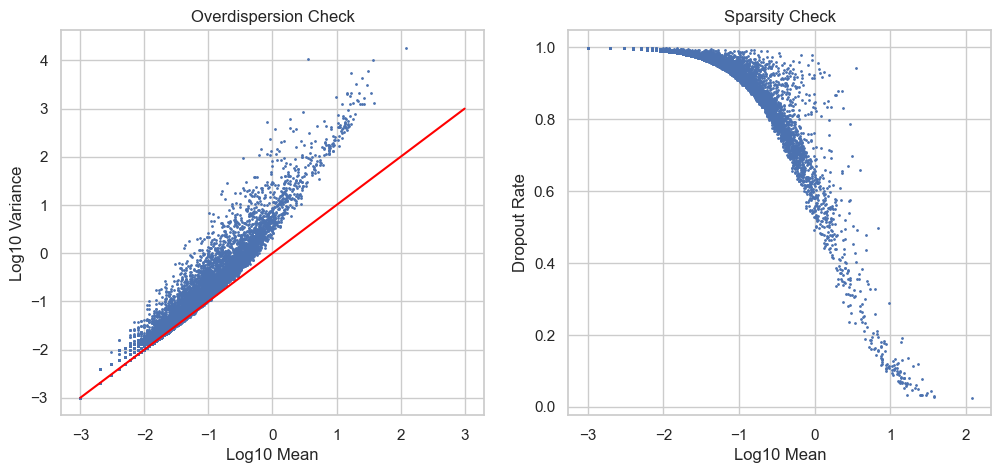

Global Sparsity: 0.919477824514796
Percentage of overdispersed genes: 86.90871522396871
Preprocessing Complete.
Min value: 0.0
Max value: 8.753845


In [32]:
# Part 1: Diagnostic Plots & Metrics

def analyze_gene_nature(X_sparse):
    # Convert to normal array because sparse is hard to work with
    X = X_sparse.toarray()
    
    # 1. Calculate basic gene statistics
    gene_means = np.mean(X, axis=0)
    gene_vars = np.var(X, axis=0)
    
    # 2. Calculate Sparsity
    total_elements = X.shape[0] * X.shape[1]
    global_sparsity = np.sum(X == 0) / total_elements
    
    # 3. Calculate Overdispersion
    # We only look at genes that are not zero
    mask = gene_means > 0
    overdispersed_genes = np.sum(gene_vars[mask] > gene_means[mask])
    pct_overdispersed = (overdispersed_genes / np.sum(mask)) * 100
    
    # --- Visualization ---
    gene_dropout_rate = np.sum(X == 0, axis=0) / X.shape[0]
    
    plt.figure(figsize=(12, 5))
    
    # Plot Mean vs Variance
    plt.subplot(1, 2, 1)
    plt.scatter(np.log10(gene_means[mask]), np.log10(gene_vars[mask]), s=1)
    # Draw a red line for reference
    plt.plot([-3, 3], [-3, 3], color='red') 
    plt.title("Overdispersion Check")
    plt.xlabel("Log10 Mean")
    plt.ylabel("Log10 Variance")
    
    # Plot Mean vs Dropout
    plt.subplot(1, 2, 2)
    plt.scatter(np.log10(gene_means[mask]), gene_dropout_rate[mask], s=1)
    plt.title("Sparsity Check")
    plt.xlabel("Log10 Mean")
    plt.ylabel("Dropout Rate")
    
    plt.show()
    
    
    print("Global Sparsity:", global_sparsity)
    print("Percentage of overdispersed genes:", pct_overdispersed)

# Run analysis
analyze_gene_nature(X_train)


# Part 2: Preprocessing 

def preprocess_rna_seq(X_sparse, target_sum=10000):
    X = X_sparse.toarray()
    
    # Calculate sum for every row (library size)
    library_size = X.sum(axis=1)
    
    # Fix rows with 0 sum to avoid division errors
    library_size[library_size == 0] = 1
    
    # Normalize: divide by library size and multiply by target
    # We use [:, None] to make the shapes match for division
    X_norm = (X / library_size[:, None]) * target_sum
    
    # Log Transform (log(1 + x))
    X_log = np.log1p(X_norm)
    
    return X_log

X_train_processed = preprocess_rna_seq(X_train)
X_test_processed = preprocess_rna_seq(X_test)

print("Preprocessing Complete.")
print("Min value:", X_train_processed.min())
print("Max value:", X_train_processed.max())

In [33]:
from sklearn.decomposition import PCA
import numpy as np

# Part 1: Feature Selection

def select_highly_variable_genes(X, n_top_genes=2000):
    # Calculate variance for every gene column
    gene_vars = np.var(X, axis=0)
    
    # Sort the variances and get the indices of the highest ones
    # We take the last 'n_top_genes' because argsort sorts low-to-high
    sorted_indices = np.argsort(gene_vars)
    top_gene_indices = sorted_indices[-n_top_genes:]
    
    # Return the data with only those columns
    return X[:, top_gene_indices], top_gene_indices

# Run the selection
X_train_hvg, hvg_indices = select_highly_variable_genes(X_train_processed, n_top_genes=2000)
# Make sure to use the same genes for the test set
X_test_hvg = X_test_processed[:, hvg_indices]

print("Original gene count:", X_train_processed.shape[1])
print("New gene count:", X_train_hvg.shape[1])


# Part 2: PCA

# Reduce the data to 50 components to make it easier for the model
pca = PCA(n_components=50, random_state=42)

X_train_pca = pca.fit_transform(X_train_hvg)
X_test_pca = pca.transform(X_test_hvg)

# Check how much information we kept
explained_var = np.sum(pca.explained_variance_ratio_)
print("Variance explained by 50 components:", explained_var)

Original gene count: 13551
New gene count: 2000
Variance explained by 50 components: 0.323694


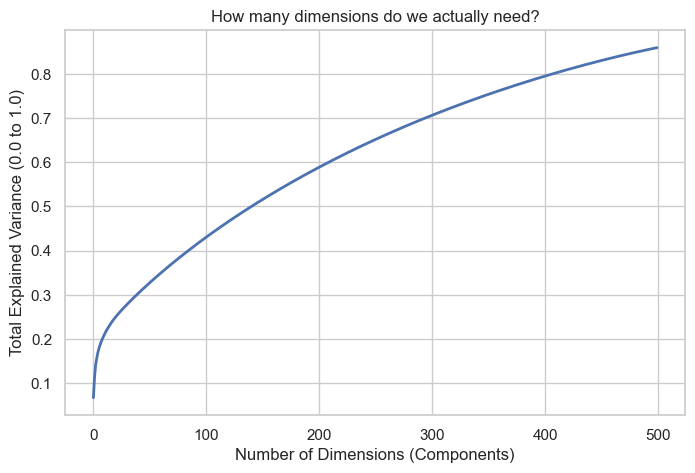

In [34]:
# 1. Fit PCA (Simple run with 500 components)
pca = PCA(n_components=500, random_state=42)
pca.fit(X_train_hvg)

# 2. Plot Cumulative Variance (The "Signal" Curve)
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)

plt.xlabel('Number of Dimensions (Components)')
plt.ylabel('Total Explained Variance (0.0 to 1.0)')
plt.title('How many dimensions do we actually need?')
plt.grid(True)
plt.show()

Running UMAP... this might take a minute.


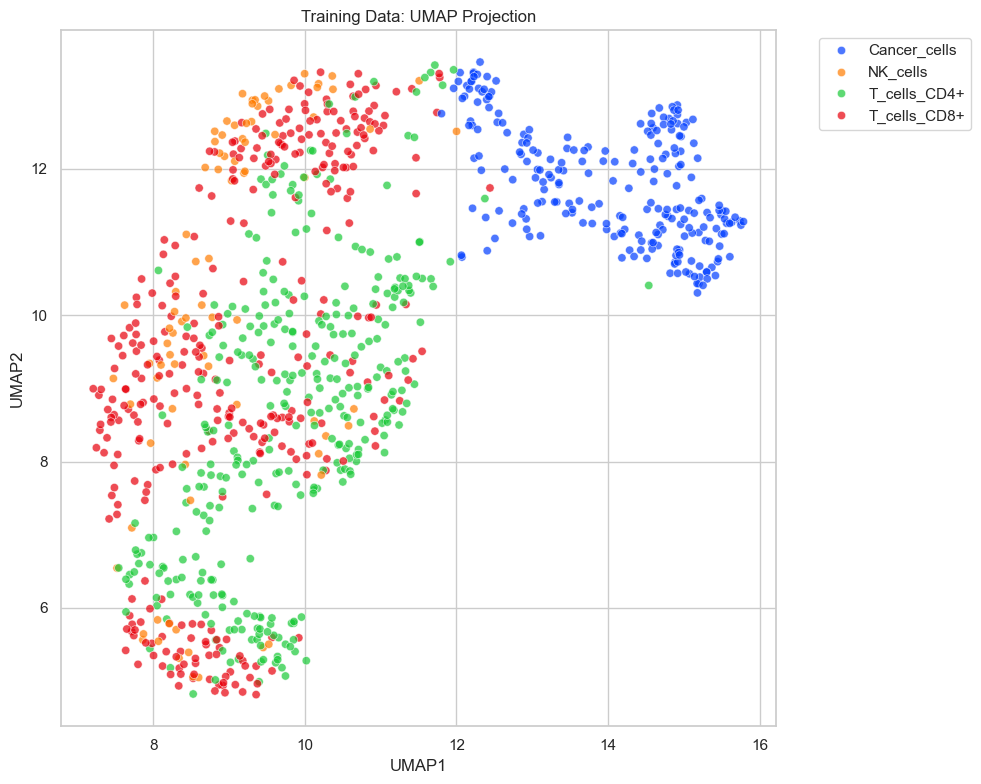

In [35]:
def visualize_cell_types_umap(X_pca, y, title="Cell Type Clusters (UMAP)"):
    print("Running UMAP... this might take a minute.")
    
    # Initialize UMAP
    # We use n_neighbors=30 to keep the global structure clean
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
    embedding = reducer.fit_transform(X_pca)
    
    # Make a simple DataFrame for seaborn to use
    df_plot = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    df_plot['Cell Type'] = y
    
    plt.figure(figsize=(10, 8))
    
    # Scatter plot with color by Cell Type
    sns.scatterplot(
        data=df_plot, 
        x='UMAP1', 
        y='UMAP2', 
        hue='Cell Type', 
        palette='bright',
        alpha=0.7  # Transparency
    )
    
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Run the UMAP visualization
visualize_cell_types_umap(X_train_pca, y_train, title="Training Data: UMAP Projection")

In [36]:
def my_norm(X):
    # Convert sparse to dense array if needed
    if hasattr(X, "toarray"):
        X = X.toarray()
        
    # Calculate library size (sum of row)
    # keepdims=True makes the shape (n, 1) so we can divide easily
    library_size = X.sum(axis=1, keepdims=True)
    library_size[library_size == 0] = 1 # Fix zeros
    
    # Normalize to 10,000 counts
    X_norm = (X / library_size) * 10000
    return np.log1p(X_norm)

def get_variance(X, y):
    # SelectKBest expects (X, y) arguments, even if we don't use y
    return np.var(X, axis=0)

# Build the Pipeline 

# This pipeline runs all our steps in order automatically
model_pipeline = make_pipeline(
    # Step 1: Normalize (using our custom function)
    FunctionTransformer(my_norm),
    
    # Step 2: Pick top 2000 variable genes
    SelectKBest(score_func=get_variance, k=2000),
    
    # Step 3: Compress to 50 dimensions
    PCA(n_components=50, random_state=42),
    
    # Step 4: The Classifier (SVM)
    SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
)

# --- 3. Run Validation ---

# We want to try a couple of settings for the SVM
# Note: 'svc__C' refers to the C parameter of the 'svc' step in the pipeline
param_grid = {
    'svc__C': [1, 10], 
    'svc__gamma': ['scale']
}

print("Starting Grid Search... this might take a minute.")

grid = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=5, # 5-fold cross validation
    scoring='balanced_accuracy',
    n_jobs=-1 # Use all CPU cores
)

# We fit on X_train (raw data) because the pipeline handles the preprocessing!
grid.fit(X_train, y_train)

print("Best CV Score:", grid.best_score_)
print("Best Parameters:", grid.best_params_)

# --- 4. Final Report ---
print("\nGenerating report...")
y_pred = cross_val_predict(grid.best_estimator_, X_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

Starting Grid Search... this might take a minute.
Best CV Score: 0.8626495725107389
Best Parameters: {'svc__C': 1, 'svc__gamma': 'scale'}

Generating report...
              precision    recall  f1-score   support

Cancer_cells       0.98      1.00      0.99       237
    NK_cells       0.85      0.71      0.77        85
T_cells_CD4+       0.90      0.86      0.88       336
T_cells_CD8+       0.83      0.89      0.85       342

    accuracy                           0.89      1000
   macro avg       0.89      0.86      0.87      1000
weighted avg       0.89      0.89      0.89      1000



Running Cross-Validation...
Mean CV Score: 0.8818111177258399
Training final model...


c:\Users\dursu\Desktop\M2 Data Science\Data Camp\scmark-classification-test-team\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Test Set Score: 0.9028994008968025

Classification Report:
              precision    recall  f1-score   support

Cancer_cells       1.00      0.97      0.99       118
    NK_cells       0.90      0.84      0.87        43
T_cells_CD4+       0.89      0.92      0.90       168
T_cells_CD8+       0.88      0.88      0.88       171

    accuracy                           0.91       500
   macro avg       0.92      0.90      0.91       500
weighted avg       0.91      0.91      0.91       500



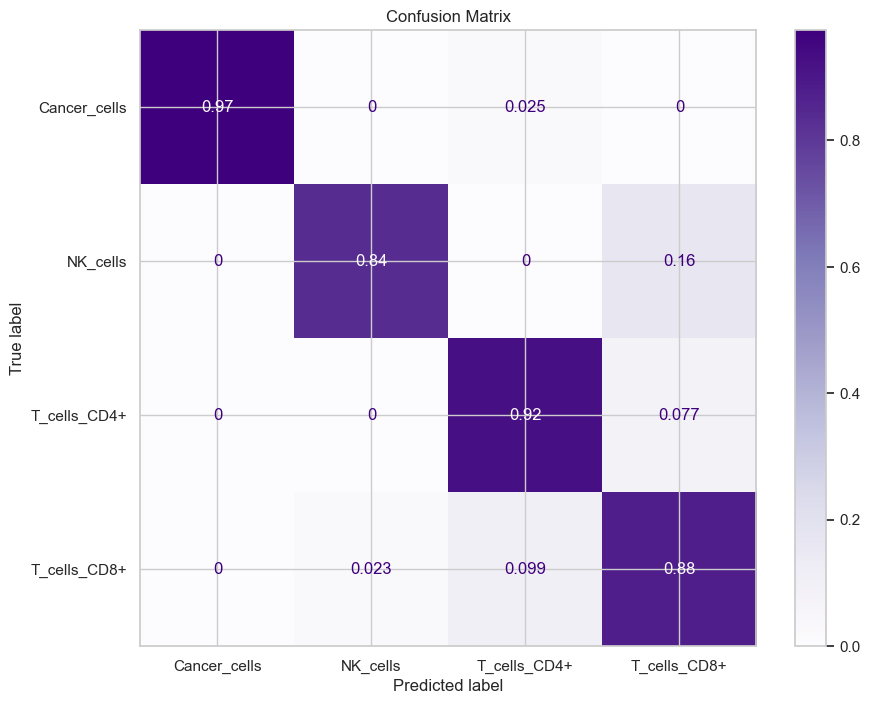

In [37]:
# 1. Custom Preprocessing
def rna_log_norm(X):
    # Convert to dense array just in case
    if hasattr(X, "toarray"):
        X = X.toarray()
    
    # Calculate library size and normalize
    library_size = X.sum(axis=1, keepdims=True)
    library_size[library_size == 0] = 1 
    return np.log1p((X / library_size) * 10000)

# 2. Custom Feature Selector
# This class picks general genes AND genes specific to immune cells
class FocusedFeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, k_general=2000, k_specific=150, 
                 specific_classes=['NK_cells', 'T_cells_CD8+', 'T_cells_CD4+']): 
        self.k_general = k_general
        self.k_specific = k_specific
        self.specific_classes = specific_classes
        self.selected_indices_ = None

    def fit(self, X, y=None):
        # Part A: General Feature Selection
        # We use f_classif (ANOVA) to find genes that separate all classes well
        if y is not None:
            f_scores, _ = f_classif(X, y)
            f_scores = np.nan_to_num(f_scores) # fix nan errors
            
            # Get indices of top general genes
            ind_general = np.argsort(f_scores)[-self.k_general:]
        else:
            # If no y, just use variance
            vars_ = np.var(X, axis=0)
            ind_general = np.argsort(vars_)[-self.k_general:]

        # Part B: Specific Immune Selection
        # We look specifically at NK vs T-cells because they are hard to tell apart
        ind_specific = np.array([], dtype=int)
        
        if y is not None:
            y_arr = np.array(y)
            # Create a mask for just the immune cells we care about
            mask = np.isin(y_arr, self.specific_classes)
            
            if mask.sum() > 0:
                X_sub = X[mask]
                y_sub = y_arr[mask]
                
                # Check if we have enough classes to compare
                if len(np.unique(y_sub)) >= 2:
                    f_scores_spec, _ = f_classif(X_sub, y_sub)
                    f_scores_spec = np.nan_to_num(f_scores_spec)
                    
                    # Get indices of top immune genes
                    ind_specific = np.argsort(f_scores_spec)[-self.k_specific:]

        # Part C: Combine both lists (Union)
        self.selected_indices_ = np.union1d(ind_general, ind_specific)
        
        return self

    def transform(self, X):
        # Return only the columns we selected
        return X[:, self.selected_indices_]

# 3. Build the Pipeline
model = make_pipeline(
    FunctionTransformer(rna_log_norm),
    # Use our custom selector
    FocusedFeatureSelector(k_general=2000, k_specific=170),
    PCA(n_components=40, random_state=42),
    SVC(C=5.0, gamma=0.001, kernel='rbf', class_weight='balanced', probability=True, random_state=42)
)

# 4. Validation (5-Fold)
print("Running Cross-Validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='balanced_accuracy', n_jobs=-1)

print("Mean CV Score:", cv_scores.mean())

# 5. Final Test
print("Training final model...")
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

test_score = balanced_accuracy_score(y_test, y_pred_test)
print("Test Set Score:", test_score)

# 6. Report and Matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test, 
    normalize='true', 
    cmap='Purples', 
    ax=ax
)
plt.title("Confusion Matrix")
plt.show()